In [1]:
from dolfinx import cpp as _cpp
from dolfinx import geometry, fem, mesh, plot, io
from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, ComplexType
from ufl import (TrialFunction, Measure, TestFunction, dx, ds, grad, div, inner, lhs, rhs)

import timeit
import numpy as np
import pandas as pd

from utils.dolfinx import BoundaryCondition, generate_boundary_measure, eval_pointvalues, project
from utils.plotting import Mpl2DPlotter

from pathlib import Path

import ufl
from matplotlib import pyplot as plt

In [2]:
save_dir = "./results/1d"
Path(save_dir).mkdir(parents=True, exist_ok=True)

In [3]:
def generate_boundaries(points):
    return [(1, lambda x: np.isclose(x[0], points[0])), 
            (2, lambda x: np.isclose(x[0], points[1]))]

In [4]:
def problem_setup(N: int,
                  points: list[float, float],
                  Theta0: float,
                  T: float,
                  dt: float,
                  fluid: str):
    """
    Performs problem configuration w.r.t. given parameters
    """
    
    # Mesh and function space definition
    domain = mesh.create_interval(MPI.COMM_WORLD, N, points)
    V = fem.FunctionSpace(domain, ("CG", 1))
    G = fem.FunctionSpace(domain, ("CG", 1))
    

    (u, theta) = TrialFunction(V), TrialFunction(G)
    (v, g) = TestFunction(V), TestFunction(G)
    
    # Definition of density and speed functions
    ro, c, eta, cv, ksi, alpha = fluids.loc[fluid, ['Density', 'Speed of sound', 'Viscosity', 
                                                    'Heat', 'Thermal conductivity', 'Thermal expansion']]
        
    # Construction of bilinear form and linear functional
    GAMMA, BETA = 0.5, 0.5
    
    mm = ScalarType(ro) * inner(u, v) * dx
    aa = ScalarType(ro * c**2) * inner(grad(u), grad(v)) * dx
    cc = ScalarType(4./3 * eta) * inner(grad(u), grad(v)) * dx
    
    ss = ScalarType(cv) * inner(theta, g) * dx
    bb_1 = ScalarType(Theta0 * alpha * eta) * inner(theta, v.dx(0)) * dx
    bb_2 = ScalarType(Theta0 * alpha * eta) * inner(g, u.dx(0)) * dx
    kk = ScalarType(ksi) * inner(grad(theta), grad(g)) * dx
    
    F = fem.form([[mm + (dt * GAMMA * cc) + (0.5 * dt * dt * BETA * aa), -dt * GAMMA * bb_1], 
                  [-dt * GAMMA * bb_2, ss + dt * GAMMA * kk]])
    
    boundaries = generate_boundaries(points)
    measure = generate_boundary_measure(boundaries, domain)
    
    u_D = lambda x: x[0] * 0.0
    theta_D = lambda x: x[0] * 0.0
    u_N1 = fem.Constant(domain, ScalarType(-1.0))
    u_N2 = fem.Constant(domain, ScalarType(0.0))
    
    bcs = [BoundaryCondition("Dirichlet", 1, u_D, V, u, v, measure).bc, 
           BoundaryCondition("Dirichlet", 1, theta_D, G, theta, g, measure).bc]
    nbcs = [BoundaryCondition("Neumann", 2, u_N1, V, u, v, measure).bc,
            BoundaryCondition("Neumann", 2, u_N2, V, u, v, measure).bc] 
    
    return {
        'Params': (N, points, fluid, ro, c, Theta0, T, dt, GAMMA, BETA),
        'FunctionSpace': (domain, V, u, v, G, theta, g),
        'Forms': (mm, aa, cc, ss, bb_1, bb_2, kk), 
        'Problem': (F, bcs, nbcs)
    }

In [5]:
def solve_problem(config):
    N, points, fluid, ro, c, Theta0, T, dt, GAMMA, BETA = config['Params']
    domain, V, u, v, G, theta, g = config['FunctionSpace']
    mm, aa, cc, ss, bb_1, bb_2, kk = config['Forms']
    F, bcs, nbcs = config['Problem']
    
    # Create initial condition
    u_initial_condition = lambda x: x[0] * 0.0
    theta_initial_condition = lambda x: x[0] * Theta0
    
    uj = fem.Function(V)
    uj_d = fem.Function(V)
    uj_d_d_tg = fem.Function(V)
    uj_dd = fem.Function(V)
    thetaj = fem.Function(G)
    thetaj_d = fem.Function(G)
    
    uj.interpolate(u_initial_condition)
    uj_d.interpolate(u_initial_condition)
    uj_d_d_tg.interpolate(u_initial_condition)
    uj_dd.interpolate(u_initial_condition)
    thetaj.interpolate(theta_initial_condition)
    thetaj_d.interpolate(theta_initial_condition)
    
    # Construct the left and right hand side of the problem
    a00 = fem.petsc.assemble_matrix(F[0][0])
    a01 = fem.petsc.assemble_matrix(F[0][1])
    a10 = fem.petsc.assemble_matrix(F[1][0])
    a11 = fem.petsc.assemble_matrix(F[1][1])
    map(PETSc.Mat.assemble, [a00, a01, a10, a11])

    A = PETSc.Mat().createNest([[a00, a01], 
                                [a10, a11]])
    A.assemble()
    
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.FIELDSPLIT)
    solver.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

    # return A
    # Solve problem at each time step,
    num_steps = int(T / dt)
    t = 0.0
    for i in range(num_steps):
        t += dt
        
        idx = 0 if t < 1.68e-6 else 1
        
        uj_d_d_tg.x.array[:] = dt * GAMMA * uj_d.x.array
        
        L = nbcs[idx] + (cc * uj_d) + (aa * uj) + (aa * uj_d_d_tg) - (bb_1 * thetaj)
        Z = (kk * thetaj) + (bb_2 * uj_d)
        
        linear_form = fem.form([rhs(L), rhs(Z)])
        
        b = fem.petsc.assemble_vector_nest(linear_form)
        # print(b.array)
        # Modify ('lift') the RHS for Dirichlet boundary conditions
        fem.petsc.apply_lifting_nest(b, F, bcs=bcs)

        # Sum contributions from ghost entries on the owner
        for b_sub in b.getNestSubVecs():
            b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

        # Set Dirichlet boundary condition values in the RHS
        bcs0 = fem.bcs_by_block(fem.extract_function_spaces(linear_form), bcs)
        fem.petsc.set_bc_nest(b, bcs0)
        
        x = PETSc.Vec().createNest([_cpp.la.petsc.create_vector_wrap(uj_dd.x), 
                                    _cpp.la.petsc.create_vector_wrap(thetaj_d.x)])
        solver.solve(b, x)
        uj_dd.x.scatter_forward()
        thetaj_d.x.scatter_forward()
      
        # Update solution
        
        uj.x.array[:] = uj.x.array + dt * uj_d.x.array + 0.5 * dt**2 * uj_dd.x.array
        uj_d.x.array[:] = uj_d.x.array + dt * uj_dd.x.array
        
        thetaj.x.array[:] = thetaj.x.array + dt * thetaj_d.x.array 
        
    return (uj, uj_d, uj_dd, thetaj, thetaj_d)

#### Available fluids

In [6]:
fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
fluids

,Density,Speed of sound,Viscosity,Heat,Thermal conductivity,Thermal expansion
Fluid,,,,,,
Water,1000,1500,0.000894,4182.0,0.598,0.00015
Fuel oil,890,1360,2.022000,NaN,NaN,NaN
Oil,760,1470,0.000500,NaN,NaN,NaN
Glycerin,1260,1905,1.500000,NaN,NaN,NaN


In [7]:
config = problem_setup(N=200, 
                       points=[0.0, 0.01],
                       Theta0=293.0,
                       T=2.025e-5,
                       dt=5.4e-9,
                       fluid='Water')

In [8]:
res = solve_problem(config)

In [9]:
uj, uj_d, uj_dd, thetaj, thetaj_d = res

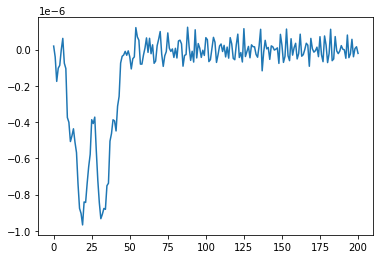

In [10]:
plt.plot(res[1].x.array)